In [25]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# TensorFlow imports
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.callbacks import TensorBoard

from datasets.radcure import config_radcure
from models.losses import Losses
from models.model import GMM_Survival
from utils.eval_utils import (accuracy_metric, calibration, cindex,
                              cindex_metric)
from utils.utils import ProgBar, get_latent, setup_env, setup_seed

tfd = tfp.distributions
tfkl = tf.keras.layers
tfpl = tfp.layers
tfk = tf.keras
# VaDeSC model

# Set Seaborn style for a cleaner look
sns.set(style="whitegrid")
setup_env()
print(os.getcwd())

CWD: /m/home/home9/97/nguyenq10/unix/HUS/cancer-clusters
GPU: /physical_device:GPU:0
/m/home/home9/97/nguyenq10/unix/HUS/cancer-clusters


## Dataset

In [26]:
from datasets.radcure import config_radcure, load_radcure
from sklearn.model_selection import train_test_split


cfg0 = config_radcure()
path = "/u/97/nguyenq10/unix/HUS/cancer-clusters/datasets/radcure/clinical_train.csv"
x, y = load_radcure(path)

x_tr, x_val, y_tr, y_val = train_test_split(
    x, y, train_size=cfg0["train_size"], random_state=cfg0["seed"])

x.shape=(1800, 45), y.shape=(1800, 2)


## VaDeSC Model

## Main Cluster

Progress: 100%|██████████| 1000/1000 [00:36<00:00, 27.77it/s, loss=23.8359, val_output_5_cindex_metric=0.7249]


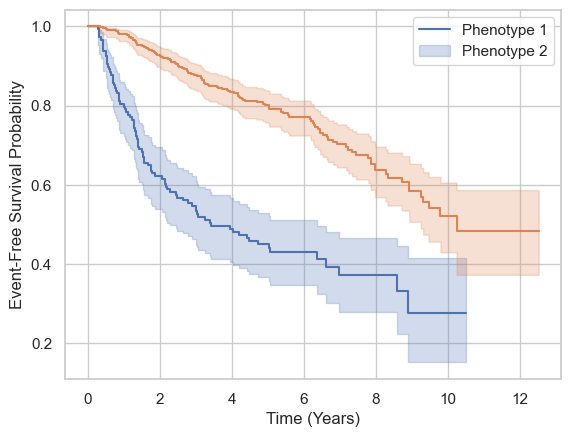

[0.1343748098593978]


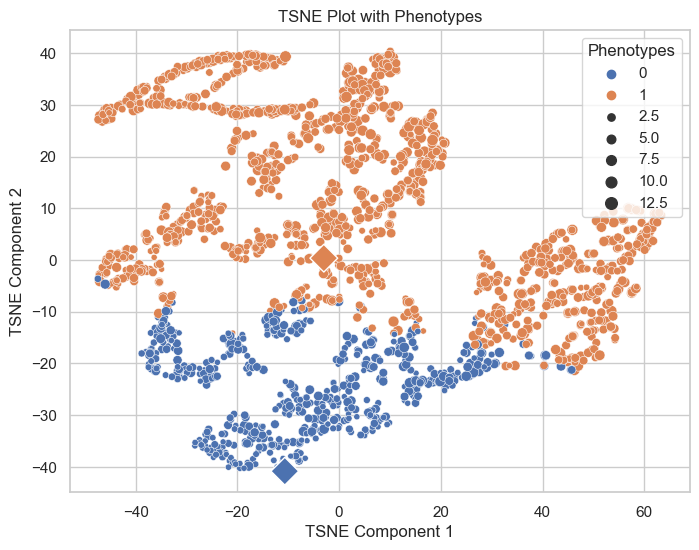

In [33]:
from copy import deepcopy
from sklearn.model_selection import ParameterGrid

from main import train
from utils.utils import get_purity


cfg0 = config_radcure()
model0, (x_tr, x_val, y_tr, y_val) = train(x, y, config=cfg0)
phe_val = model0.get_phenotypes(x_val, y_val)
print(get_purity(y_val, phe_val))
get_latent(model0, x, y)

## Cluster Analysis

In [32]:
def train_shuffled(params, base_cfg, Nsub=0.5):
    base_cfg["train_size"] = Nsub
    models, Cruns, x_indices = [], [], []
    for param in params:
        cfg = {k: param[k] if k in param else v for k, v in cfg0.items()}
        print(cfg)
        model, (x_tr, x_val, y_tr, y_val) = train(x, y, config=cfg)
        x_indices.append(list(x_tr.index))
        Cruns.append(model.get_phenotypes(x_tr, y_tr))
        phe_val = model.get_phenotypes(x_val, y_val)
        purity = get_purity(y_val, phe_val)
        models.append([model, cfg, purity])
    return Cruns, x_indices, models


param_grid = {
    "seed": range(100),
    "num_clusters": [2],
    "latent_dim": [8],
    "epochs": [1000],
}

params = ParameterGrid(param_grid)

#   - Append the cluster labels to the cluster_labels list
#   cluster_labels.append(Cruns.labels)
N = len(x)
K = cfg0["num_clusters"]
runs = len(params)
Nsub = int(N*0.5)
Cruns, x_indices, models = train_shuffled(params, cfg0)

NameError: name 'base_cfg' is not defined

In [ ]:
I = np.zeros((runs, N, N))
M0 = np.zeros((runs, N, N))

for run in range(runs):
    idx = np.array(x_indices[run])
    mask = np.zeros(N, dtype=bool)
    mask[idx] = True
    mask_mat = np.outer(mask, mask)
    I[run] = mask_mat.astype(int)

    labels = np.array(Cruns[run])
    label_mat = np.equal.outer(labels, labels)
    idx_mat = np.ix_(idx, idx)
    M0[run][idx_mat] = label_mat

M = np.nan_to_num(np.sum(M0, axis=0) / np.sum(I, axis=0))
M

ValueError: shape mismatch: value array of shape (540,540) could not be broadcast to indexing result of shape (1260,1260)

In [ ]:
rec, z_sample, p_z_c, p_c_z, risks, lambdas = best_model.predict(
    (x.values, y.values),batch_size=len(x))
Cmain = np.argmax(p_c_z, -1)

def consensus_idx(Cmain, k, M=M):
    Ck = np.where(Cmain == k)[0]
    if len(Ck) > 1:
        # Select the relevant sub-matrix for cluster k
        Mk = M[np.ix_(Ck, Ck)]
    
        # Sum above the diagonal elements to get consensus sum for unique pairs
        consensus_sum = np.sum(np.triu(Mk,1))
    
        # Number of unique pairs in cluster k is "N choose 2"
        num_pairs = len(Ck) * (len(Ck) - 1) / 2
    
        # Calculate the consensus index for cluster k
        return consensus_sum / num_pairs
    else:
        # Handle the case where a cluster may have only one element
        return 0

m = []
for k in range(K):
    m.append(consensus_idx(Cmain,k))

# consensus_indices
m

1/1 [==============================] - 0s 15ms/step


[0.504849012775842, 0.5202102990564529]

In [ ]:
# 1. H0: the consensus index is the same regardless of cluster assignments
# 2. test statistics is consensus index
# distribution 
#


In [ ]:
P = 10000
p_values = []
for k in range(K):
    mk_perms = [] 
    for p in range(P):
        Cmain_p = np.random.permutation(Cmain)
        mkp = consensus_idx(Cmain_p,k)
        mk_perms.append(mkp)
    # Calculate the p-value for the observed consensus index
    p_value = (np.sum(mk_perms >= consensus_idx(Cmain,k)) + 1) / (P + 1)  # Adding 1 to the numerator and denominator for continuity correction
    p_values.append(p_value)
    
p_values

[9.999000099990002e-05, 9.999000099990002e-05]